**Name**: Diran Suraj

**PI**: Z7279378

# TM358 TMA 03 Question 3 (25 Marks)

# Introduction

In this question of TMA 03, you are researching how a convolution autoencoder could be used to de-blur old photographs. The question uses a dataset of buildings created by the analytics team, the images were blurred using a algorithm in MAX/MSP https://cycling74.com (Max is an interactive, visual patching environment for musicians and artists).

The dataset has been adapted so that the images are 150x150 in size.

There is also a test dataset of blurred images to investigate the performance of the model.

## Completing the TMA

The tasks in this notebook can be addressed using the techniques discussed in Blocks 1 to 5 of the module materials, and the associated notebooks.

You should be able to complete this question when you have completed the practical activities in Block 5.

You should look at the notebooks for Block 3 while working through this question. You will find many useful examples in those notebooks which will help you in this assignment.

Record all your activity and observations in this notebook. Insert additional notebook cells as required. 

Include Markdown cells (like this one) liberally in your solutions, to describe what you are doing. This will help your tutor give full credit for all you have done, and is invaluable in reminding you what you were doing when you return to the TMA after a few days away.

See the VLE for details of how to submit your completed notebook. You should submit only this notebook file for this question.

## Important note about training and saving the model

Ensure that the code cell where you train the model also includes saving of the model and training history. This is a large dataset and models will take some time to train. You can leave the model to train while you do something else (ensure your PC does not go to sleep). 

Once training is finished and the container is idle, it will shut down after a while. If you save the model as soon as it has finished training (in the same notebook cell), you can load the model on your return. If you don't save the model, you will lose that work. 

Below is an example of how to do this.

## Marks are based on process, not results

In this notebook, you will be asked to create, train, and evaluate several neural networks. Training neural networks is inherently a stochastic process, based on the random allocation of initial weights and the shuffled order of training examples. Therefore, your results will differ from results generated by other students, and those generated by the module team and presented in the tutor's marking guide.

The marks in this question are awarded solely on your ability to carry out the steps of training and evaluation, not on any particular results you may achieve. **There are no thresholds for accuracy (or any other metric) you must achieve.** You will gain credit for carrying out the tasks specified in this question, including honest evaluations of how the models perform. 

## Importing the required libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import matplotlib.pyplot as plt
%matplotlib inline
import os

## Creating some constants

In [3]:
BATCH_SIZE=64

# Define the size of the images used
IMAGE_SHAPE = (64, 64, 3)

In [4]:
def load_image(image_path):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    image /= 255.0
    return image
    # return image, image

## Loading the data

In [5]:
base_dir = '/datasets'

In [6]:
train_original_names = tf.data.Dataset.list_files(os.path.join(base_dir, 'train-out/*.jpg'),shuffle=False)
train_original = train_original_names.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
train_blurred_names = tf.data.Dataset.list_files(os.path.join(base_dir, 'train-blur/*.jpg'),shuffle=False)
train_blurred = train_blurred_names.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
train_dataset = tf.data.Dataset.zip(train_blurred, train_original)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None))>

In [9]:
test_original_names = tf.data.Dataset.list_files(os.path.join(base_dir, 'train-out/*.jpg'),shuffle=False)
test_original = test_original_names.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
test_blurred_names = tf.data.Dataset.list_files(os.path.join(base_dir, 'train-blur/*.jpg'),shuffle=False)
test_blurred = test_blurred_names.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
test_dataset = tf.data.Dataset.zip(test_blurred, test_original)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None))>

### Show the original and blurred training files

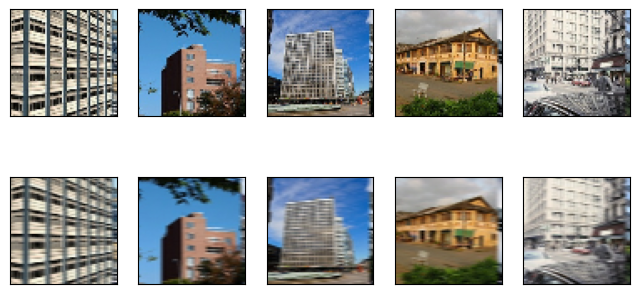

In [12]:
blurred_images, original_images = train_dataset.as_numpy_iterator().next()

num_images = 5
# View data
plt.figure(figsize=(8,4))

for i in range(num_images):
    
    plt.subplot(2,num_images,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(original_images[i])
    plt.subplot(2,num_images,i+1+num_images)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blurred_images[i])
plt.show()

## Defining some functions

The following creates some functions for use in the autoencoder, including a pixel shuffler.

In [13]:

# PixelShuffler layer for Keras
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.layers import Layer
from tensorflow.python.keras.utils.conv_utils import normalize_data_format
import tensorflow.keras.backend as K


class PixelShuffler(Layer):
    # Initialize the sub-pixel convolution layer, and standardize the data when input data.
    def __init__(self, size=(2, 2), data_format=None, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.size = conv_utils.normalize_tuple(size, 2, 'size')

    def call(self, inputs):
        input_shape = K.int_shape(inputs)
        batch_size, h, w, c = input_shape
        if batch_size is None:
            batch_size = -1
        rh, rw = self.size

        # Calculate the converted layer size and the number of channels
        oh, ow = h * rh, w * rw
        oc = c // (rh * rw)

        # First, separate the layers and change each layer to its proper dimension
        # Then, use the reshape function again and convert into a layer of the specified size
        out = K.reshape(inputs, (batch_size, h, w, rh, rw, oc))
        out = K.permute_dimensions(out, (0, 1, 3, 2, 4, 5))
        out = K.reshape(out, (batch_size, oh, ow, oc))
        return out

    # compute_output_shape() function prints the size of the output dimensions of the layer.
    # The dimensions are calculated based on the input_shape and the output_shape we define.
    def compute_output_shape(self, input_shape):
        height = input_shape[1] * self.size[0] if input_shape[1] is not None else None
        width = input_shape[2] * self.size[1]  if input_shape[2] is not None else None
        channels = input_shape[3] // self.size[0] // self.size[1]

        return (input_shape[0],
                height,
                width,
                channels)

    # Setting the configuration file
    def get_config(self):
        config = {'size': self.size,
                  'data_format': self.data_format}
        base_config = super(PixelShuffler, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))

In [14]:
# Filters are the number of passes in the output layer
# n * n * c -> 0.5n * 0.5n * filters
def conv(filters):
    def block(x):
        # Each layer consists of a convolution layer that reduces the layer size by half and a LeakyReLU activation function layer.
        x = layers.Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
        x = layers.LeakyReLU(0.1)(x)
        return x
    return block

# Step up the sampling layer and increase the size of the layer.
# The shape of this layer changes as follows:
# n*n*c -> n * n * 4filters -> 2n * 2n * filters
def upscale(filters):
    # Each layer consists of a convolution of an enlarged channel layer, an activation function and a pixel shuffle layer
    def block(x):
        # Quadruple the number of channels. The next step is to double the size of the original layer by shuffling pixels
        x = layers.Conv2D(filters*4, kernel_size=3, padding='same')(x)
        x = layers.LeakyReLU(0.1)(x)
        x = PixelShuffler()(x)
        return x
    return block
    

## Defining an Encoder and Decoder

In [15]:
ENCODER_DIM=1024
def Encoder():
    input_ = layers.Input(shape=IMAGE_SHAPE)
    x = conv(64)(input_)
    x = conv(128)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(ENCODER_DIM)(x)
    x = layers.Dense(4*4*128)(x)
    x = layers.Reshape((4, 4, 128))(x)
    x = upscale(64)(x)
    return models.Model(input_, x)

def Decoder():
    input_ = layers.Input(shape=(8, 8, 64))
    x = upscale(128)(input_)
    x = upscale(256)(x)
    x = upscale(64)(x)
    x = layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
    return models.Model(input_, x)

In [16]:
# Define the optimizer

optimizer = optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.999)
encoder = Encoder()
decoder = Decoder()

# Define the input function size
x = layers.Input(shape=IMAGE_SHAPE)

# Defining a neural network for parsing class A images
autoencoder = models.Model(x, decoder(encoder(x)))

# Using the same optimizer and loss function
autoencoder.compile(optimizer=optimizer, loss='mean_absolute_error')
# our two autoencoders
autoencoder

<Functional name=functional_5, built=True>

In [17]:
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 8, 8, 64)       │    36,159,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 64, 64, 3)      │     2,070,979 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,230,595 (145.84 MB)

 Trainable params: 38,230,595 (145.84 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = autoencoder.fit(train_dataset, epochs=20)

Epoch 1/20


I0000 00:00:1742737223.367584      53 service.cc:145] XLA service 0x7f821c006140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742737223.367627      53 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.2443 

I0000 00:00:1742737232.228532      53 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 821ms/step - loss: 0.2427
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2405
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2279
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2255
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2182
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2123
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2118
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2013
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1934
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1835
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1729
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1741
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1690
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1648
Epoch 15/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1653
Epoch 16/20
1

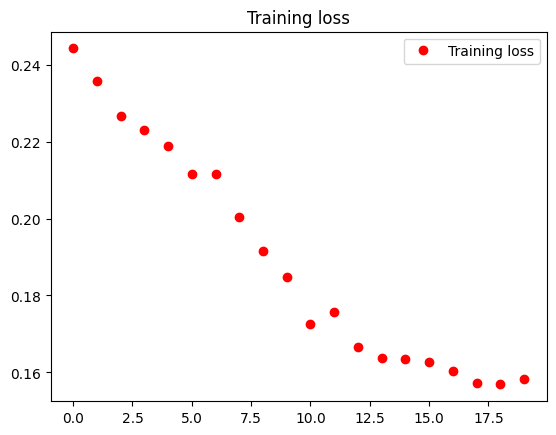

In [20]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

## Model saving

In [21]:
autoencoder.save_weights('autoencoder_1.weights.h5')

In [22]:
autoencoder.load_weights('autoencoder_1.weights.h5')

## Model testing

Test model on training data

In [23]:
# Utility function to avoid repition below
def show_sub_img(location, title, image):
    plt.subplot(2,3,location)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.grid(False)
    plt.imshow(image)

In [24]:
train_blurred, train_original = train_dataset.as_numpy_iterator().next()
train_prediction = autoencoder.predict(train_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


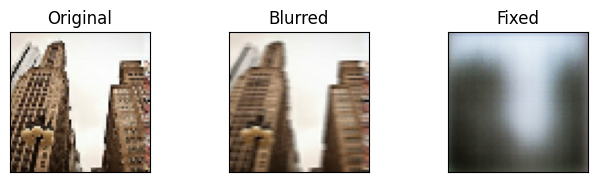

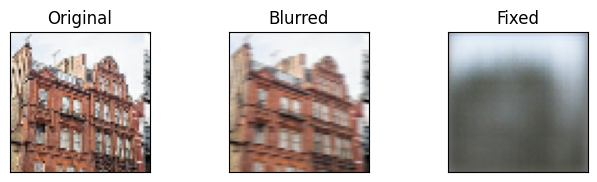

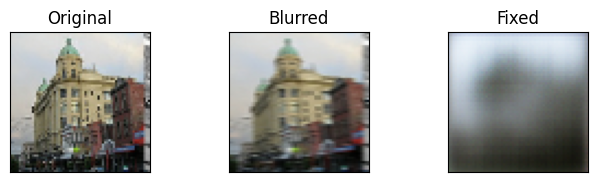

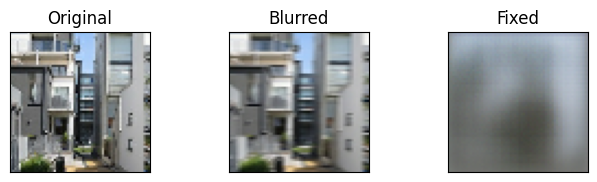

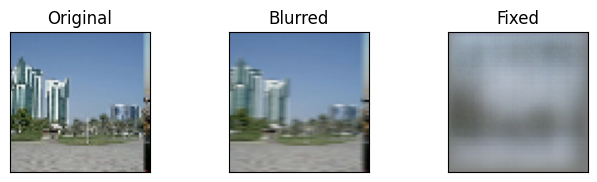

In [25]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', train_original[i])
    show_sub_img(2, 'Blurred', train_blurred[i])
    show_sub_img(3, 'Fixed', train_prediction[i])

    plt.show()

In [26]:
test_blurred, test_original = test_dataset.as_numpy_iterator().next()
test_prediction = autoencoder.predict(test_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


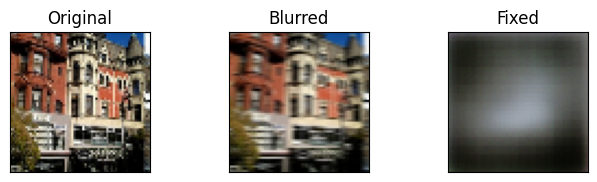

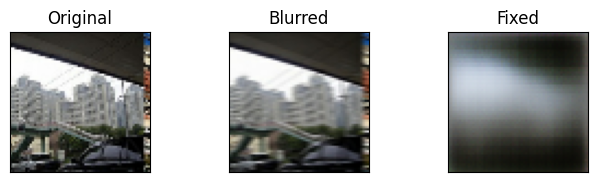

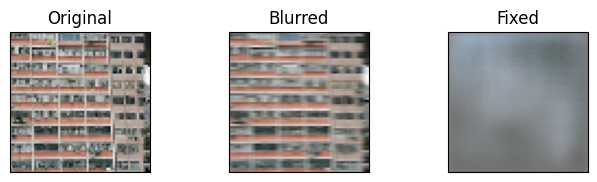

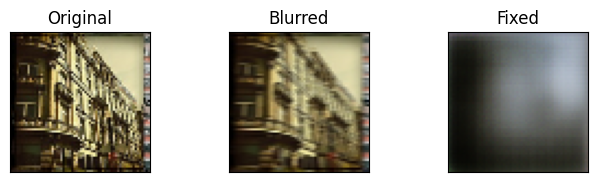

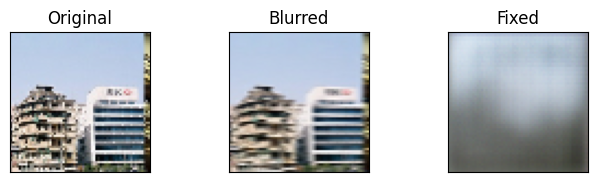

In [27]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', test_original[i])
    show_sub_img(2, 'Blurred', test_blurred[i])
    show_sub_img(3, 'Fixed', test_prediction[i])

    plt.show()

test model on test data

# You are now ready to attempt this section of TMA 03

# Q3a - Increase the training epochs (5 marks)

As can be seen from the first run of the training, the model is not performing well on either recreating the original images or fixing the test blurred images.

In this question you are required to investigate the impact of increased training epochs.

## Testing the impact of more training

* Create a new version of the model above.

* Train the model for 500 epochs to see if the model performance improves.

* Produce and output of the training history

* Produce an output of 5 training images (original, blurred and fixed) for the new model.
* Produce an output of 5 test images (original, blurred and fixed) for the new model.

Comment on your results - has increasing the number of epochs improved the performance of the model - is further training justified?


In [18]:
history = autoencoder.fit(train_dataset, epochs=500)

Epoch 1/500


I0000 00:00:1742817866.445287      56 service.cc:145] XLA service 0x7f70a8007250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742817866.445327      56 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


 3/10 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2438

I0000 00:00:1742817874.968632      56 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 810ms/step - loss: 0.2444
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.2395
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2241
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2205
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2174
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2099
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2068
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1988
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1857
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.2079
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1742
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1708
Epoch 13/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1684
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1665
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.1616

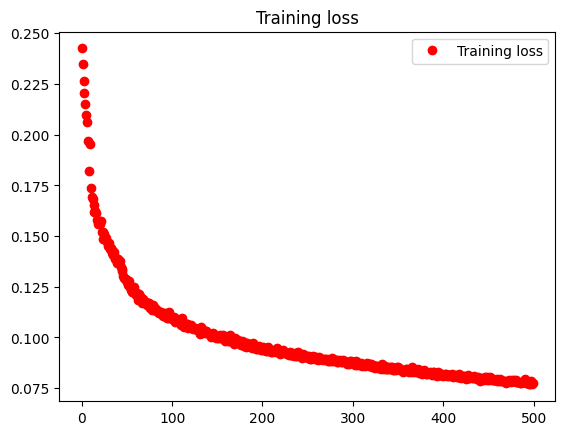

In [19]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [20]:
# Utility function to avoid repition below
def show_sub_img(location, title, image):
    plt.subplot(2,3,location)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.grid(False)
    plt.imshow(image)

In [21]:
train_blurred, train_original = train_dataset.as_numpy_iterator().next()
train_prediction = autoencoder.predict(train_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


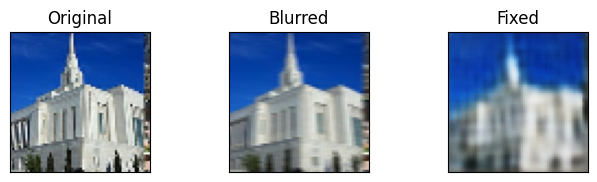

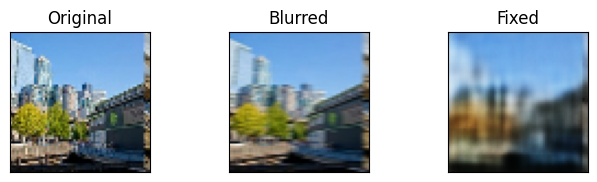

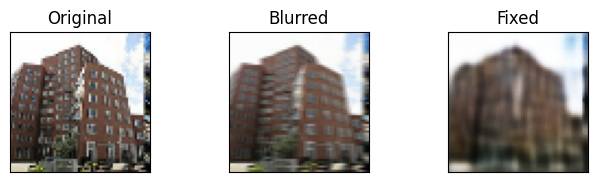

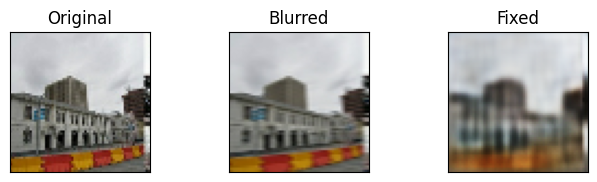

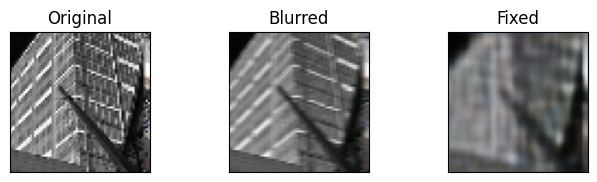

In [22]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', train_original[i])
    show_sub_img(2, 'Blurred', train_blurred[i])
    show_sub_img(3, 'Fixed', train_prediction[i])

    plt.show()

In [23]:
test_blurred, test_original = test_dataset.as_numpy_iterator().next()
test_prediction = autoencoder.predict(test_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


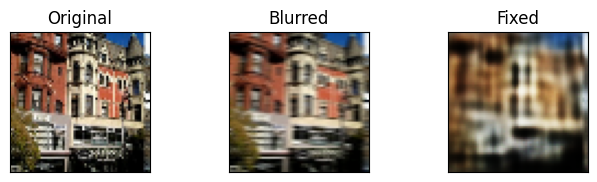

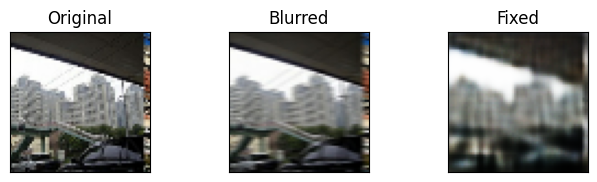

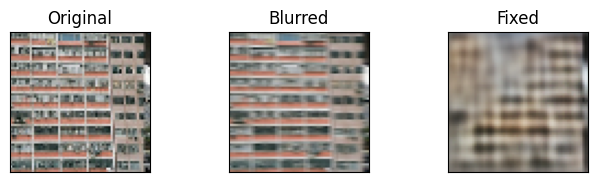

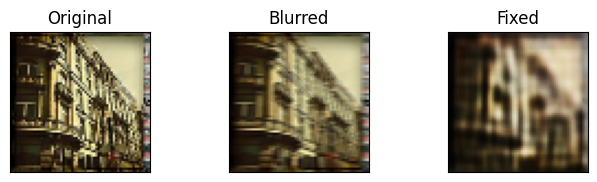

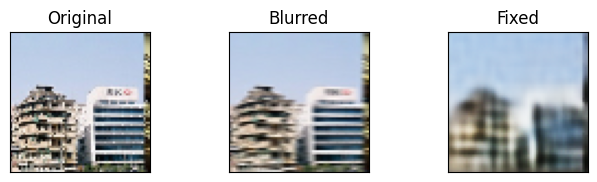

In [24]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', test_original[i])
    show_sub_img(2, 'Blurred', test_blurred[i])
    show_sub_img(3, 'Fixed', test_prediction[i])

    plt.show()

It appears that increasing the number of epochs from 20 to 500 has increased the performance of the model for both the training and test datasets. The 'fixed' images appear to show more resemblance to the original images (more colours and shapes coming through) for both the test and training datasets despite being quite blurry. Whereas for the previous model the 'fixed' images showed little to no resemblance.

The training loss slowly decreased after around 100 epochs and did not plateau, so the model could likely be trained for more epochs for better results. 

# Q3(b) - Changing the structure of the autoencoder (13 marks)

## Adjust the structure of the autoencoder as follows:
---
Encoder:
* `input_ = layers.Input(shape=IMAGE_SHAPE)`
* four convolution layers of 128, 256, 512 and 1024
* The dense and reshape layers as follows:

    `x = layers.Dense(ENCODER_DIM)(layers.Flatten()(x))`
  
    `x = layers.Dense(4*4*1024)(x)`

    `x = layers.Reshape((4, 4, 1024))(x)`

    `x = upscale(512)(x)`

Decoder:

* `input_ = layers.Input(shape=(8, 8, 512))`
* three upscale layers in the order 256, 128, and 64
* a final layer using `x = layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)`

---

Train your model for 500 epochs with the same optimiser and loss as the example model.

Refer to the example encoder and module notebook examples.

Print out the following:
* a summary of the model
* the training history

Save and load your encoder weights. 

Display original, blurred and fixed images using your model for 5 training images.

Display original blurred and fixed images using for model for 5 test images.

Comment on the training and the performance of the model on the test and training images.

In [25]:
ENCODER_DIM=1024
def Encoder():
    input_ = layers.Input(shape=IMAGE_SHAPE)
    x = conv(128)(input_)
    x = conv(256)(x)
    x = conv(512)(x)
    x = conv(1024)(x)
    x = layers.Dense(ENCODER_DIM)(layers.Flatten()(x))
    x = layers.Dense(4*4*1024)(x)
    x = layers.Reshape((4, 4, 1024))(x)
    x = upscale(512)(x)
    return models.Model(input_, x)

def Decoder():
    input_ = layers.Input(shape=(8, 8, 512))
    x = upscale(256)(input_)
    x = upscale(128)(x)
    x = upscale(64)(x)
    x = layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
    return models.Model(input_, x)

In [26]:
# Define the optimizer

optimizer = optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.999)
encoder = Encoder()
decoder = Decoder()

# Define the input function size
x = layers.Input(shape=IMAGE_SHAPE)

# Defining a neural network for parsing class A images
autoencoder = models.Model(x, decoder(encoder(x)))

# Using the same optimizer and loss function
autoencoder.compile(optimizer=optimizer, loss='mean_absolute_error')
# our two autoencoders
autoencoder

<Functional name=functional_11, built=True>

In [27]:
autoencoder.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 8, 8, 512)      │    69,662,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_9 (Functional)       │ (None, 64, 64, 3)      │     6,199,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,862,723 (289.39 MB)

 Trainable params: 75,862,723 (289.39 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = autoencoder.fit(train_dataset, epochs=500)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - loss: 0.2446
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.2445
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.2322
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.2256
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.2184
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.2181
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.2051
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1938
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1866
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1867
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1818
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1824
Epoch 13/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1768
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1753
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 17

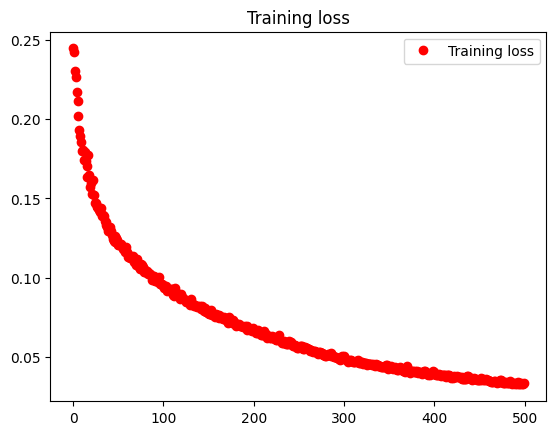

In [29]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [30]:
autoencoder.save_weights('autoencoder_1b.weights.h5')

In [31]:
autoencoder.load_weights('autoencoder_1b.weights.h5')

In [32]:
# Utility function to avoid repition below
def show_sub_img(location, title, image):
    plt.subplot(2,3,location)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.grid(False)
    plt.imshow(image)

In [33]:
train_blurred, train_original = train_dataset.as_numpy_iterator().next()
train_prediction = autoencoder.predict(train_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


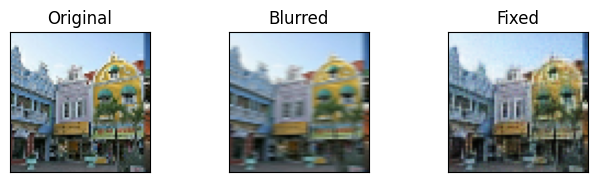

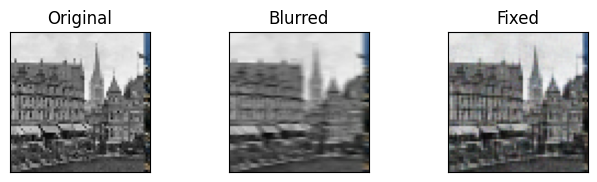

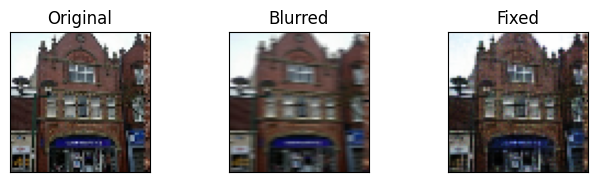

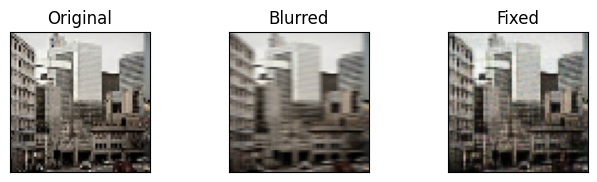

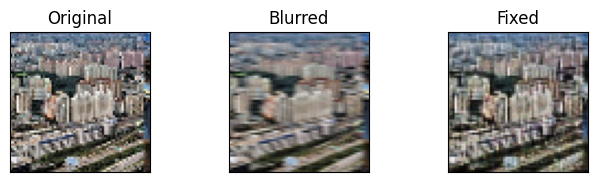

In [34]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', train_original[i])
    show_sub_img(2, 'Blurred', train_blurred[i])
    show_sub_img(3, 'Fixed', train_prediction[i])

    plt.show()

In [35]:
test_blurred, test_original = test_dataset.as_numpy_iterator().next()
test_prediction = autoencoder.predict(test_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


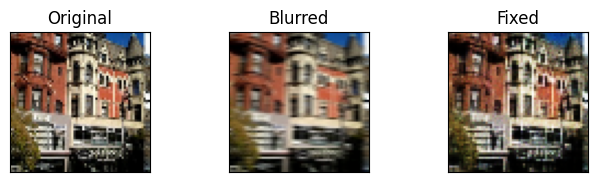

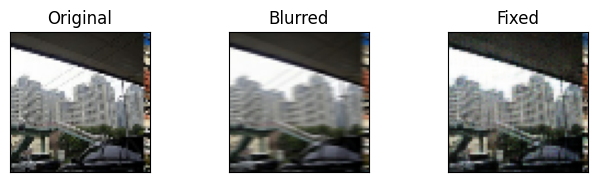

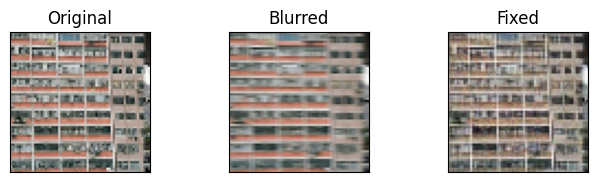

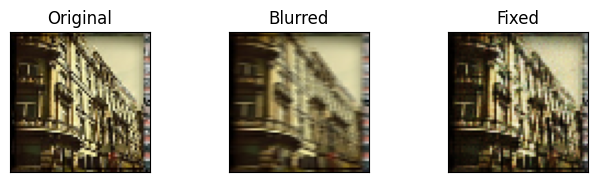

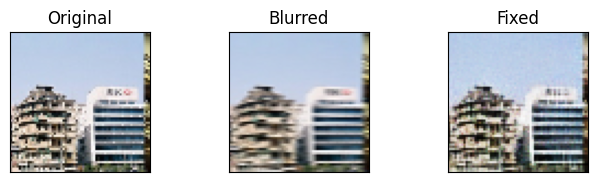

In [36]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', test_original[i])
    show_sub_img(2, 'Blurred', test_blurred[i])
    show_sub_img(3, 'Fixed', test_prediction[i])

    plt.show()

It appears that making the autoencoder more powerful has increased the performance of the model for both the training and test datasets. The 'fixed' images appear to show significant resemblance to the original images to where it is harder to tell the difference for both the test and training datasets.

The training loss slowly decreased after around 300 epochs and did not plateau, so the model could likely be trained for more epochs for better results. 

# Q3(c) - Adding in a normalisation layer (7 marks)

Add in a normalisation layer to the model in Q3(b), train using the same structure and hyperparameters that you have used in Q3(b) for 500 epochs.

Print the following:
* a summary of the model
* the training graph
* 5 training images for the autoencoder in Q3(b) and Q3(c) - (original, blurred, predicted output from autoencoder Q3(b) and predicted output from autoencoder Q3(c))
* 5 test training images for the autoencoder in Q3(b) and Q3(c) - (original, blurred, predicted output from autoencoder Q3(b)and predicted output from autoencoder Q3(c)).

Comment on your results - compare the output with respect to your model in Q3(b).

In [37]:
ENCODER_DIM=1024
def Encoder():
    input_ = layers.Input(shape=IMAGE_SHAPE)
    x = layers.BatchNormalization()(input_)
    x = conv(128)(x)
    x = conv(256)(x)
    x = conv(512)(x)
    x = conv(1024)(x)
    x = layers.Dense(ENCODER_DIM)(layers.Flatten()(x))
    x = layers.Dense(4*4*1024)(x)
    x = layers.Reshape((4, 4, 1024))(x)
    x = upscale(512)(x)
    return models.Model(input_, x)

def Decoder():
    input_ = layers.Input(shape=(8, 8, 512))
    x = upscale(256)(input_)
    x = upscale(128)(x)
    x = upscale(64)(x)
    x = layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
    return models.Model(input_, x)

In [38]:
# Define the optimizer

optimizer = optimizers.Adam(learning_rate=5e-5, beta_1=0.5, beta_2=0.999)
encoder = Encoder()
decoder = Decoder()

# Define the input function size
x = layers.Input(shape=IMAGE_SHAPE)

# Defining a neural network for parsing class A images
autoencoder3c = models.Model(x, decoder(encoder(x)))

# Using the same optimizer and loss function
autoencoder3c.compile(optimizer=optimizer, loss='mean_absolute_error')
# our two autoencoders
autoencoder3c

<Functional name=functional_17, built=True>

In [39]:
autoencoder3c.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_13 (Functional)      │ (None, 8, 8, 512)      │    69,662,988 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_15 (Functional)      │ (None, 64, 64, 3)      │     6,199,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,862,735 (289.39 MB)

 Trainable params: 75,862,729 (289.39 MB)

 Non-trainable params: 6 (24.00 B)

In [40]:
history = autoencoder3c.fit(train_dataset, epochs=500)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - loss: 0.2448
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - loss: 0.2383
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.2134
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.2069
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1991
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1938
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1807
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1659
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.1579
Epoch 10/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1559
Epoch 11/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1544
Epoch 12/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.1532
Epoch 13/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1558
Epoch 14/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.1487
Epoch 15/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s

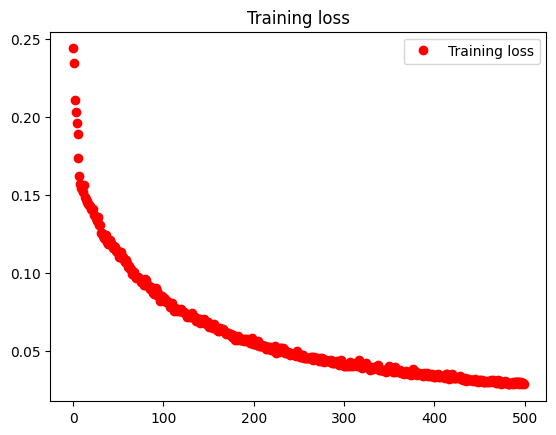

In [41]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [49]:
# Utility function to avoid repetition below
def show_sub_img(location, title, image):
    plt.subplot(2,3,location)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.grid(False)
    plt.imshow(image)

In [50]:
train_blurred, train_original = train_dataset.as_numpy_iterator().next()
train_prediction = autoencoder.predict(train_blurred) #train_prediction for model in Q3b
train_prediction3c = autoencoder3c.predict(train_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


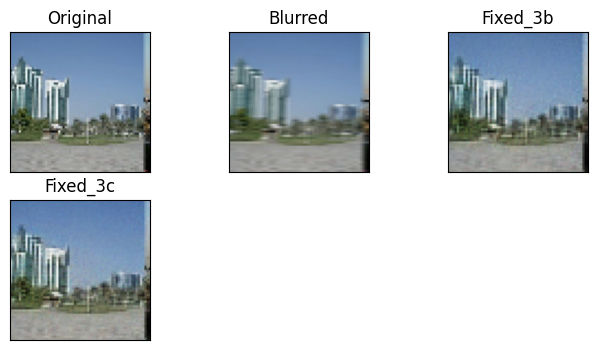

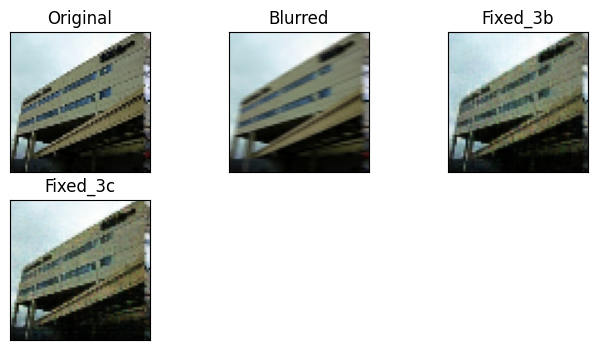

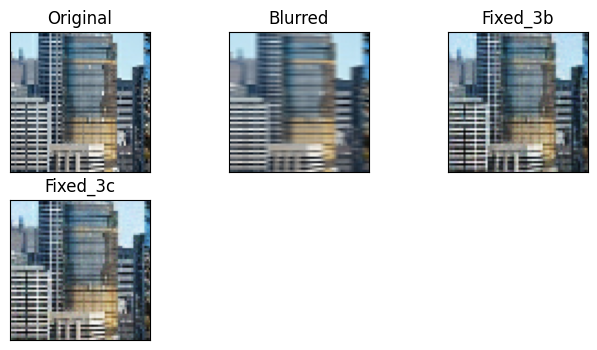

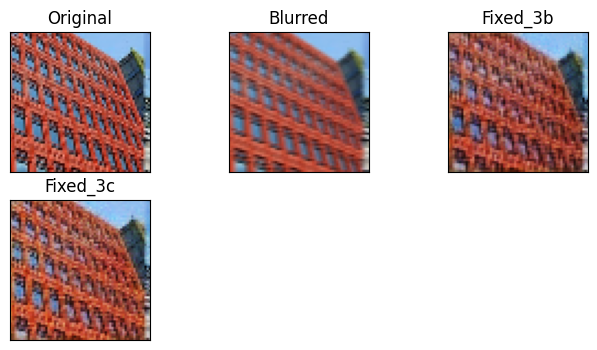

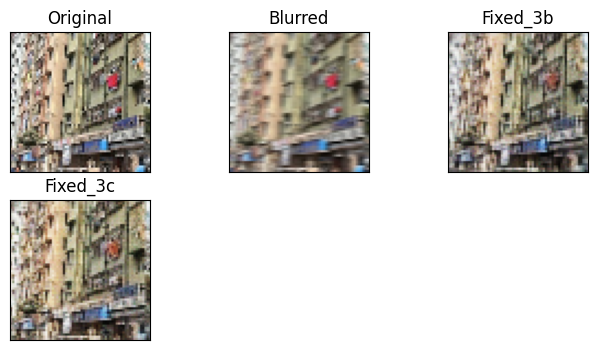

In [51]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', train_original[i])
    show_sub_img(2, 'Blurred', train_blurred[i])
    show_sub_img(3, 'Fixed_3b', train_prediction[i])
    show_sub_img(4, 'Fixed_3c', train_prediction3c[i])

    plt.show()

In [52]:
test_blurred, test_original = test_dataset.as_numpy_iterator().next()
train_prediction = autoencoder.predict(train_blurred) #test_prediction for model in Q3b
test_prediction3c = autoencoder3c.predict(test_blurred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


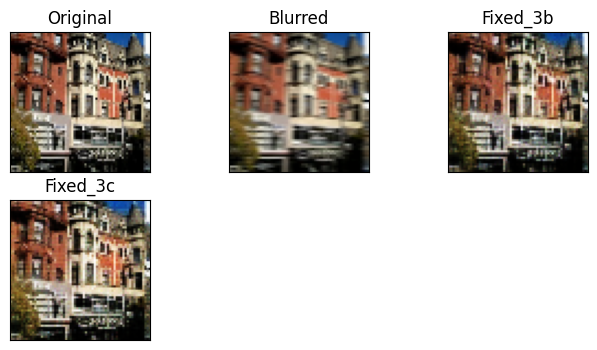

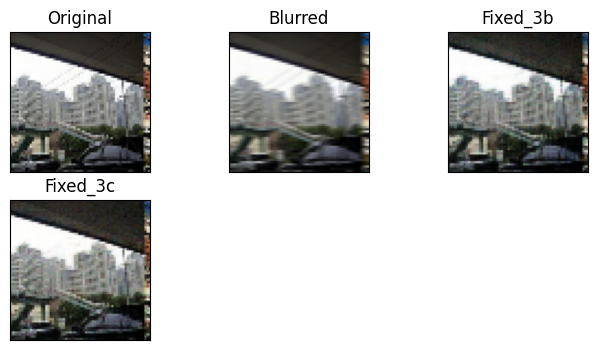

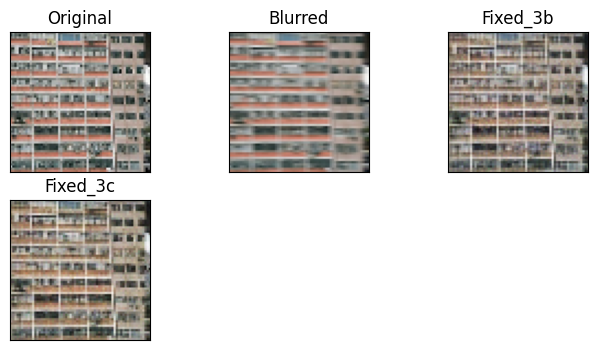

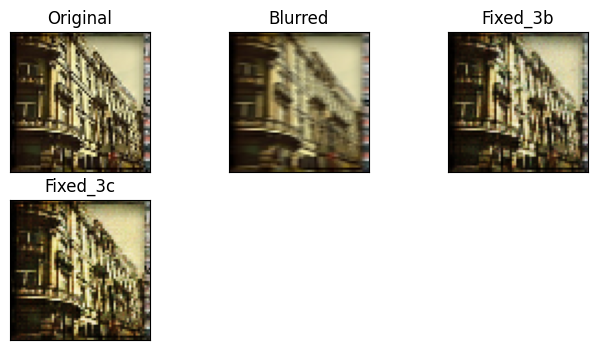

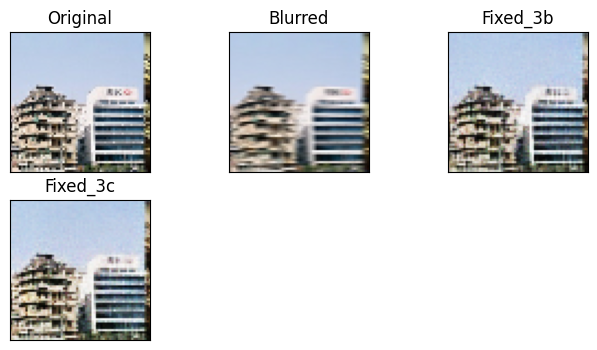

In [53]:
for i in range(20,25):    
    # View data
    plt.figure(figsize=(8,4))

    show_sub_img(1, 'Original', test_original[i])
    show_sub_img(2, 'Blurred', test_blurred[i])
    show_sub_img(3, 'Fixed_3b', test_prediction[i])
    show_sub_img(4, 'Fixed_3c', test_prediction3c[i])

    plt.show()

###### 

Adding the normalisation layer has not appeared to make a significant difference to the images compared to the model in 3b. Between the original and the fixed images from the models in 3b and 3c, the difference is not discernible for both the test and training datasets.

The only fixed image that does not exactly resemble the original would be the 3rd image for the test dataset for both the 3b and 3c models - the colour in the image is less saturated. Overall, adding the normalisation layer may not be entirely necessary. 

The training loss slowly decreased after around 300 epochs and did not plateau, so the model could likely be trained for more epochs for better results. 